In [1]:
import numpy as np
import pickle
from tqdm import tqdm
from tfld import utils, tfld
from libci import utils
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
def warn(*args, **kwargs):
    pass
# import warnings
warnings.warn = warn
import matplotlib.pyplot as plt

from ecgdetectors import Detectors


%load_ext autoreload
%autoreload 2

downsample_factor=7
detectors =Detectors(int(700 / downsample_factor))

dir_ = '/mnt/WESAD'
S_str = [str(i) for i in range(1, 18) if i not in [1,12,15]]

sfreq=700

2023-02-08 21:30:30.201519: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 21:30:30.206493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 21:30:30.206513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def bit_and(a, b):
    a = a.astype(int)
    b = b.astype(int)
    
    and_ = a * b
    return and_.astype(bool)

def bit_or(a, b):
    a = a.astype(int)
    b = b.astype(int)
    
    or_ = a + b - (a*b)
    
    return or_.astype(bool)

def get_raw_ecg_and_labels(dir_, subject_id_str_list, labels_to_keep=[1,2], downsample_factor=7):
    raw_ecg = []
    labels = []
    
    if len(labels_to_keep) != 2:
        raise ValueError("two class analysis only")
        
    for i, S in enumerate(subject_id_str_list):
        file = f"{dir_}/S{S}/S{S}.pkl"

        with open(file, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            p = u.load()
            
        temp_labels = p['label']
        a, b = temp_labels == labels_to_keep[0], temp_labels == labels_to_keep[1]
        
        raw_ecg.append(p['signal']['chest']['ECG'].T[0][bit_or(a, b)][::downsample_factor])
        labels.append(p['label'][bit_or(a, b)][::downsample_factor] % 2)
        
    return raw_ecg, labels

def get_data_segments(ts, sfreq=700, p=0.1, n_seconds_per_window=45):
    if p == 1:
        return ts
    
    n_ts = len(ts)
    
    buffer = int(n_seconds_per_window * sfreq)
    start_index = np.random.randint(buffer, n_ts - buffer - int(p * n_ts))
    end_index = start_index + int(p * n_ts)
        
    return ts[:start_index], ts[start_index:end_index], ts[end_index:]

def get_train_test_indices(y, sfreq, n_seconds_per_window=45, n_seconds_overlap=30, p=0.1):    
    indices_by_class = {c: np.where(y == c)[0] for c in np.unique(y)}
    
    train = []
    test = []
    
    train_labels = []
    test_labels = []
    
    for c in np.unique(y):
        segments = get_data_segments(indices_by_class[c], sfreq, p)
        
        if p == 1:
            windowed_segment = utils.get_time_windows(segments, sfreq, n_seconds_per_window, n_seconds_overlap)
            train.append(windowed_segment[:, 0])
            train_labels.append(c * np.ones(len(windowed_segment)))
        else:
            for i, s in enumerate(segments):
                windowed_segment = utils.get_time_windows(s, sfreq, n_seconds_per_window, n_seconds_overlap)

                if i == 1:
                    train.append(windowed_segment[:, 0])
                    train_labels.append(c * np.ones(len(windowed_segment)))
                else:
                    test.append(windowed_segment[:, 0])
                    test_labels.append(c * np.ones(len(windowed_segment)))

    if p == 1:
        return {'indices': np.vstack(train).astype(int), 'y': np.hstack(train_labels)}
    else:
        return {'train': {'indices': np.vstack(train).astype(int), 'y': np.hstack(train_labels)},
                'test': {'indices': np.vstack(test).astype(int), 'y': np.hstack(test_labels)}
               }


def get_oracle_alpha(X, y, in_task, combined, h=0.01):    
    oracle_bacc = 0
    alpha_grid = np.arange(0,1+h, h)
    for i, alpha in enumerate(alpha_grid):
        temp_proj = alpha * in_task + (1 - alpha) * combined

        t = X @ temp_proj

        preds = (t >= 0).astype(int)
        temp_bacc = bas(y, preds)

        if temp_bacc >= oracle_bacc:
            oracle_bacc = temp_bacc
            alpha_oracle = alpha
            
    return alpha_oracle

In [3]:
"""
A collection of heartrate variability algorithms for
both the timedomain and frequency domain.
Copyright (C) 2019 Luis Howell & Bernd Porr
GPL GNU GENERAL PUBLIC LICENSE Version 3, 29 June 2007
"""


import numpy as np
import random
import subprocess
from scipy.interpolate import interp1d
from gatspy.periodic import LombScargleFast

class HRV:
    """
    Heartrate variability class which calcualtes the standard HRV
    parameters with the help of Python functions and for cross
    validation also via the physionet's get_hrv script.
    """

    def __init__(self, sampling_frequency):
        """
        Constructor takes the sampling frequency.
        All rr_sample data is in sample number and
        will assume it's at this sampling rate.
        """

        self.fs = float(sampling_frequency)
        self.period = 1.0/sampling_frequency

    
    def _intervals(self, rr_samples):
        """Calculate the RR intervals in ms from sample numbers.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: RR intervals in milliseconds
        :rtype: ndarray
        """

        rr_intervals = np.diff(np.array(rr_samples)*self.period*1000)

        return rr_intervals

    
    def _timestamps(self, rr_samples):
        """Calculate the timestamps in ms from sample locations.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: The timestamps in milliseconds
        :rtype: array_like
        """

        ts = np.array(rr_samples)*self.period*1000

        return ts

    
    def _succ_diffs(self, rr_samples):
        """Calculate the successive differences of R peaks.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: The successive differences of R peaks
        :rtype: ndarray
        """

        rr_ints = self._intervals(rr_samples)

        succ_diffs = []

        for i in range(len(rr_ints)-1):

            diff = rr_ints[i+1] - rr_ints[i]            
            succ_diffs.append(diff)

        return np.array(succ_diffs)

   
    def SDNN(self, rr_samples, normalise=False):
        """Calculate SDNN, the standard deviation of NN intervals.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param normalise: normalise the SDNN against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: SDNN, the standard deviation of NN intervals
        :rtype: float
        """

        rr_intervals = self._intervals(rr_samples) 
        rr_std = np.std(rr_intervals)

        if normalise:
            rr_mean_interval = np.mean(rr_intervals)
            rr_std = rr_std/rr_mean_interval

        return rr_std

    
    def SDANN(self, rr_samples, average_period=5.0, normalise=False):
        """Calculate SDANN, the standard deviation of the average RR intervals calculated over short periods.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param average_period: The averging period in minutes, defaults to 5.0
        :type average_period: float, optional
        :param normalise: normalise the SDANN against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: SDANN, the standard deviation of the average RR intervals calculated over short periods
        :rtype: float
        """

        average_period_samples = int(self.fs*average_period*60)
        average_rr_intervals = []

        sections = int((np.max(rr_samples)/average_period_samples)+0.5)

        if sections<1:
                sections = 1

        for i in range(sections):

                idx = np.where((rr_samples>=(i*average_period_samples)) &
                               (rr_samples<((i+1)*average_period_samples)))
                idx = idx[0]
                section_rr = rr_samples[idx[0]:idx[-1]+1]

                avg_rr_int = np.mean(self._intervals(section_rr))
                average_rr_intervals.append(avg_rr_int)

        rr_std = np.std(average_rr_intervals)

        if normalise:
                rr_mean_interval = np.mean(average_rr_intervals)
                rr_std = rr_std/rr_mean_interval

        return rr_std


    def RMSSD(self, rr_samples, normalise = False):
        """Calculate RMSSD (root mean square of successive differences).
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :param normalise: normalise the RMSSD against the average RR interval, defaults to False
        :type normalise: bool, optional
        :return: RMSSD (root mean square of successive differences)
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)
        succ_diffs = succ_diffs*succ_diffs

        rms = np.sqrt(np.mean(succ_diffs))

        if normalise:
            rms = rms / np.mean(self._intervals(rr_samples))

        return rms


    def SDSD(self, rr_samples):
        """Calculate SDSD (standard deviation of successive differences), the standard deviation of the successive differences between adjacent NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: SDSD (standard deviation of successive differences)
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        return np.std(succ_diffs)        

    
    def NN50(self, rr_samples):
        """Calculate NN50, the number of pairs of successive NNs that differ by more than 50 ms.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: NN50
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        over_50 = np.where(abs(succ_diffs)>50)
        over_50 = over_50[0]

        return len(over_50)


    def pNN50(self, rr_samples):
        """Calculate pNN50, the proportion of NN50 divided by total number of NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: pNN50
        :rtype: float
        """

        return self.NN50(rr_samples)/(len(rr_samples)-1)


    def NN20(self, rr_samples):
        """Calculate NN20, the number of pairs of successive NNs that differ by more than 20 ms.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: NN20
        :rtype: float
        """

        succ_diffs = self._succ_diffs(rr_samples)

        over_20 = np.where(abs(succ_diffs)>20)
        over_20 = over_20[0]

        return len(over_20)


    def pNN20(self, rr_samples):
        """Calculate pNN20, the proportion of NN20 divided by total number of NNs.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: pNN20
        :rtype: float
        """

        return self.NN20(rr_samples)/(len(rr_samples)-1)

    
    def HR(self, rr_samples):
        """Calculate heart-rates from R peak samples.
        
        :param rr_samples: R peak sample locations
        :type rr_samples: array_like
        :return: Heart-rates in BPM
        :rtype: ndarray
        """
        
        rr_intervals = np.diff(rr_samples)
        heart_rates = 60.0/(rr_intervals/float(self.fs))

        return heart_rates


    def add_rr_error(self, rr_samples, error):
        """
        Adds jitter to the heartrate timestamps. 
        The error and the rr_samples are in timestamps.
        Returns the noisy timestamps in samples.
        """
        if error==0:
            return rr_samples

        error_values = np.random.randint(-abs(error), abs(error)+1, len(rr_samples))
        noisy_rr_samples = rr_samples+error_values

        return noisy_rr_samples

    
    def fAnalysis(self, rr_samples):
        """
        Frequency analysis to calc self.lf, self.hf, returns the LF/HF-ratio and
        also calculates the spectrum as pairs of (self.f_hr_axis,self.f_hr).
        The input arrary is in sample points where R peaks have been detected.
        """
        # discrete timestamps
        self.hr_discrete = self._intervals(rr_samples) / 1000
        # hr positions in time
        self.t_hr_discrete  = [i/self.fs for i in rr_samples[1:]]
        # now let's create function which approximates the hr(t) relationship
        self.hr_func = interp1d(self.t_hr_discrete, self.hr_discrete)
        # we take 1024 samples for a linear time array for hr(t)
        nsamp = 1000
        # linear time array for the heartrate
        self.t_hr_linear = np.linspace(self.t_hr_discrete[1],
                                       self.t_hr_discrete[len(self.t_hr_discrete)-2],
                                       num=nsamp)
        # duration in secs of the heartrate array minus the ends b/c of the approx
        duration = self.t_hr_discrete[len(self.t_hr_discrete)-2] - self.t_hr_discrete[1];
        # heartrate linearly approximated between discrete samples
        self.hr_linear = self.hr_func(self.t_hr_linear)
        model = LombScargleFast(silence_warnings=True).fit(self.t_hr_discrete, self.hr_discrete, 1E-2)
        fmax = 1
        fmin = 0.01
        df = (fmax - fmin) / nsamp
        self.f_hr = model.score_frequency_grid(fmin, df, nsamp)
        self.f_hr_axis = fmin + df * np.arange(nsamp)
        # lf
        self.lf = 0
        # hf
        self.hf = 0
        for i in range(0,int(nsamp/2)):
            if (self.f_hr_axis[i] >= 0.04) and (self.f_hr_axis[i] <= 0.15):
                self.lf = self.lf + self.f_hr[i]
            if (self.f_hr_axis[i] >= 0.15) and (self.f_hr_axis[i] <= 0.4):
                self.hf = self.hf + self.f_hr[i]
        # hf
        return self.lf/self.hf

In [4]:
#- Loading is not instant 
ecg_list, label_list = get_raw_ecg_and_labels(dir_, S_str)
n_tasks=len(ecg_list)

In [5]:
from scipy.stats import mode

def get_windowed_labels(labels, windows):
    windowed_labels= []
    
    for w in windows:
        temp = labels[w]
        
#         print(temp)
        windowed_labels.append(int(mode(temp)[0]))
        
    return np.array(windowed_labels)

def get_features(ecg, windows, sfreq=100):
    hrv_obj = HRV(sfreq)
    X = []

    for window in windows:
        features = []
        rr_samples = detectors.hamilton_detector(ecg[window])

        features.append(hrv_obj.pNN20(rr_samples))
        features.append(hrv_obj.SDNN(rr_samples, normalise=True))
        features.append(hrv_obj.fAnalysis(rr_samples))

        X.append(features)

    return np.array(X)

In [26]:
X_list = []
y_list = []

nspw=15
nso=0

for i in range(n_tasks):
    windows = utils.get_time_windows(np.arange(len(ecg_list[i])), 100, nspw, nso).astype(int)[:, 0]
    features = get_features(ecg_list[i], windows)
    
    X_list.append(features)
    y_list.append(get_windowed_labels(label_list[i], windows))
    
print(len(X_list[0]), np.unique(y_list[0], return_counts=True)[1])

118 [42 76]


In [27]:
from sklearn.metrics import balanced_accuracy_score as bas
from graspologic.cluster import GaussianCluster as GMM
from tfld.tfld import FLD

def wesad_experiment(X, y, p, grid=0.1, n_samples_to_estimate_risk=100, bootstrap_variance=False,
                             remove_tasks=False, acorn=None):
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    if acorn is not None:
        np.random.seed(acorn)
        
    assert len(X) == len(y)
    n_tasks = len(X)
            
    train_inds = [tfld.even_sample_inds(y_, p=1, continuous=True).astype(int) for y_ in y]
    scalers = [tfld.TranslateStandardScale().fit(X[i][train_inds[i]], y[i][train_inds[i]]) for i in range(n_tasks)]
    
    projections = []
    covs = []
    for i in range(n_tasks):
        X_ = scalers[i].transform(X[i])
        
        fld = FLD()
        fld.fit(X_[train_inds[i]], y[i][train_inds[i]])
                
        covs.append(fld.cov_)
        projections.append(fld.projection_)
                
    accuracies = np.zeros((n_tasks, 5))
    alphas = np.zeros((n_tasks, 2))
    for i in range(n_tasks):
        train_inds = tfld.even_sample_inds(y[i], p=p, continuous=True)
        scaler = tfld.TranslateStandardScale().fit(X[i][train_inds], y[i][train_inds])
        
        X_ = scaler.transform(X[i])
        fld = FLD().fit(X_[train_inds], y[i][train_inds])
        target_vector = fld.projection_
        pooled_cov = fld.cov_
        class_1_mean = fld.means_[1]
        
        #- average-source projection vector
        indices_to_include = np.array([j for j in range(n_tasks) if j != i])
        source_projs = [projections[j] for j in indices_to_include]
        
        average_source_vector = tfld.estimate_mu(source_projs)
                                
        optimal_alpha = tfld.get_optimal_alpha(len(train_inds), class_1_mean, source_projs, 
                                               grid, n_samples_to_estimate_risk=n_samples_to_estimate_risk, 
                                               cov=pooled_cov, variance_from_target=None, variance_from_combined=None)
        optimal_proj = optimal_alpha * target_vector + (1 - optimal_alpha) * average_source_vector
            
            
        alphas[i,0] = optimal_alpha
        
        #- oracle projection vector
        test = [j for j in range(len(X[i])) if j not in train_inds]
        
        oracle_alpha = get_oracle_alpha(X_[test], y[i][test], target_vector, average_source_vector, h=grid)
        oracle_proj = oracle_alpha * target_vector + (1 - oracle_alpha) * average_source_vector
        alphas[i,1] = oracle_alpha
        
        #- Evaluation
        pred = (X_[test] @ target_vector >= 0).astype(int)
        accuracies[i, 0] = bas(y[i][test], pred)
    
        pred = (X_[test] @ average_source_vector >= 0).astype(int)
        accuracies[i, 1] = bas(y[i][test], pred)
        
        pred = (X_[test] @ optimal_proj >= 0).astype(int)
        accuracies[i, 2] = bas(y[i][test], pred)
        
        pred = (X_[test] @ oracle_proj >= 0).astype(int)
        accuracies[i, 3] = bas(y[i][test], pred)
        
        random_accuracies = np.zeros(100)
        for j in range(100):
            random_alpha = np.random.choice(np.arange(0,1+grid, grid), size=1)[0]
            random_proj = random_alpha * target_vector + (1 - random_alpha) * average_source_vector
            pred = (X_[test] @ random_proj >= 0).astype(int)
            random_accuracies[j] = bas(y[i][test], pred)
            
        accuracies[i, 4] = np.mean(random_accuracies)
    
    return accuracies, alphas

In [56]:
from joblib import Parallel, delayed

np.random.seed(1)

n_mc = 100
n_jobs=30
p_list = [0.05, 0.1, 0.2, 0.5]

accuracies = np.zeros((len(p_list), n_mc, n_tasks, 5))
alphas = np.zeros((len(p_list), n_mc, n_tasks, 2))
for i, p in enumerate(tqdm(p_list)):
    f = lambda x: cross_subject_experiment(X_list, y_list, p, grid=0.1)
    
    results = Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))
    
    for j, (accuracy, alpha) in enumerate(results):
        accuracies[i,j] = accuracy
        alphas[i,j] = alpha
    
    print(i, np.mean(np.mean(accuracies, axis=1), axis=1)[i])

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]2023-02-10 01:34:59.569922: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 01:34:59.576469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 01:34:59.576522: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-10 01:34:59.935502: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differen

2023-02-10 01:35:03.070040: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 01:35:03.070040: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 01:35:03.076026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 01:35:03.076032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot ope

 25%|█████████████████████▎                                                               | 1/4 [00:31<01:33, 31.32s/it]

0 [0.65341575 0.66052901 0.6773228  0.72530755 0.66623125]


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:49<00:47, 23.77s/it]

1 [0.69419829 0.66225161 0.69834341 0.73924432 0.68351349]


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [01:08<00:21, 21.49s/it]

2 [0.71114307 0.66530586 0.71119921 0.74819569 0.69164824]


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:27<00:00, 21.79s/it]

3 [0.7367318  0.65798485 0.73621083 0.76515802 0.69684229]


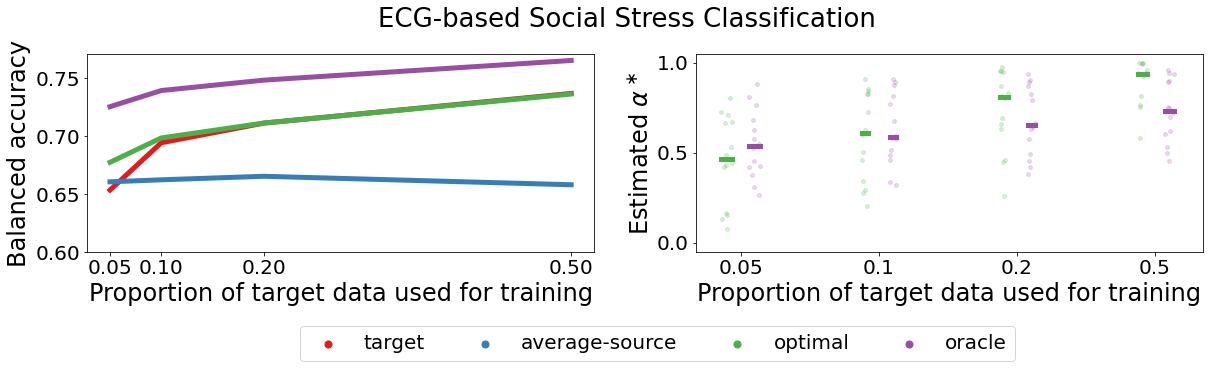

In [57]:
import seaborn as sns

mean_accuracies = np.mean(np.mean(accuracies, axis=1), axis=1)

fig, ax = plt.subplots(1,2, figsize=(20,5))

algos = ['target', 'average-source', 'optimal', 'oracle', 'random']
colors = sns.color_palette("Set1", n_colors=len(algos)+1)

fontsize=24
labelsize=20
for i, mean in enumerate(mean_accuracies.T[:-1]):
    ax[0].plot(p_list, mean, color=colors[i], lw=5)

xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

for i, algo in enumerate(algos[:-1]):
    ax[0].scatter(-1,-1, label=algos[i], color=colors[i], s=50)
    

ax[0].set_ylim(*ylim)
ax[0].set_xlim(*xlim)

ax[0].set_ylabel('Balanced accuracy', fontsize=fontsize)
ax[0].set_xlabel('Proportion of target data used for training', fontsize=fontsize)
ax[0].set_xticks(p_list)
ax[0].tick_params(labelsize=labelsize)
ax[0].set_yticks([0.6, 0.65, 0.7, 0.75])


mean_alphas = np.mean(alphas, axis=1)
for i, means in enumerate(mean_alphas):
    temp_norms = np.random.normal(i, 0.02, size=n_tasks)
    
    optimals = means[:, 0]
    oracles = means[:, 1]
    
    ax[1].scatter(temp_norms - 0.1, optimals, s=15, alpha=0.2, color=colors[2])
    ax[1].scatter(temp_norms + 0.1, oracles, s=15, alpha=0.2, color=colors[3])
        

    ax[1].plot(np.sort(temp_norms) - 0.1, n_tasks * [np.median(optimals)], lw=5, color=colors[2])
    ax[1].plot(np.sort(temp_norms) + 0.1, n_tasks * [np.median(oracles)], lw=5, color=colors[3])
    
ax[1].scatter(-1,-1, s=20, alpha=1, color=colors[2], label='optimal')
ax[1].scatter(-1,-1, s=20, alpha=1, color=colors[3], label='oracle')

ax[1].set_ylim(-0.05, 1.05)
ax[1].set_xlim(-0.33)

ax[1].set_ylabel(r'Estimated $\alpha^\ast$', fontsize=fontsize)
ax[1].set_xlabel('Proportion of target data used for training', fontsize=fontsize)
ax[1].tick_params(labelsize=labelsize)
    
ax[1].set_xticks(np.arange(len(p_list)), p_list)

fig.suptitle('ECG-based Social Stress Classification', fontsize=fontsize+2)
plt.subplots_adjust(bottom=0.3, top=0.85)
ax[0].legend(fontsize=20, loc='lower left', ncol=4, bbox_to_anchor=(0.4, -0.6, 0.1, 0.2))

plt.savefig('social_stress_ecg_bas_and_alphas.pdf', bbox_inches="tight")

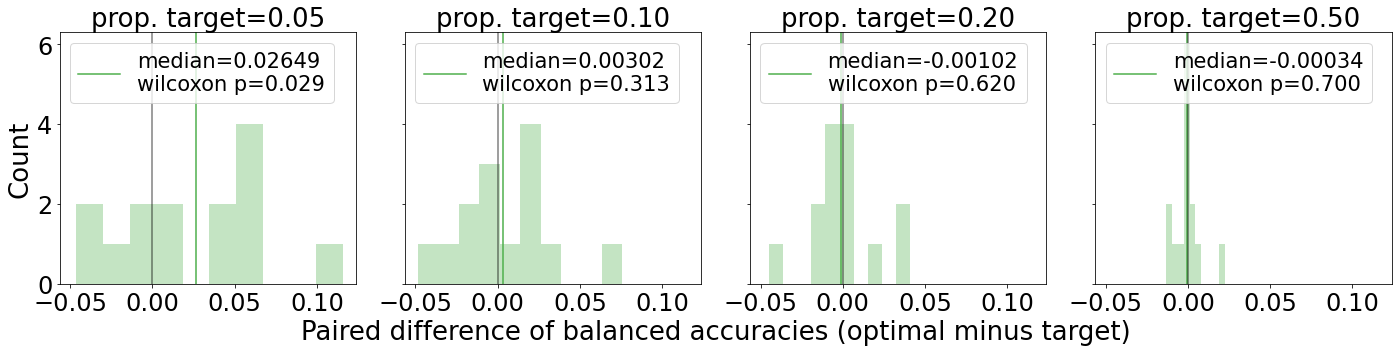

In [58]:
from scipy.stats import wilcoxon

fig, axes = plt.subplots(1, len(p_list), figsize=(20,5), sharex=True, sharey=True)

mean_by_subject = np.mean(accuracies, axis=1)
optimal_minus_in_task = mean_by_subject[:, :, 2] - mean_by_subject[:,:,0]

for i, ax in enumerate(axes):
    temp = optimal_minus_in_task[i]
    mean = np.median(temp)
    T, p_ = wilcoxon(temp, alternative='greater')
    
    ax.hist(temp, alpha=0.33, color=colors[2])
    ax.set_title('prop. target=%1.2f'%(p_list[i]), fontsize=26)
        
    ax.axvline(x=mean, label='median=%1.5f\nwilcoxon p=%1.3f'%(mean, p_), color=colors[2])
    ax.axvline(x=0, c='k', alpha=0.5)
    
    ax.legend(fontsize=21, loc='upper left')
    ax.tick_params(labelsize=24)

    
axes[0].set_ylabel('Count', fontsize=26)
axes[1].set_xlabel('Paired difference of balanced accuracies (optimal minus target)', x=1.05, fontsize=26)

plt.tight_layout()
plt.savefig('social_stress_histograms.pdf')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


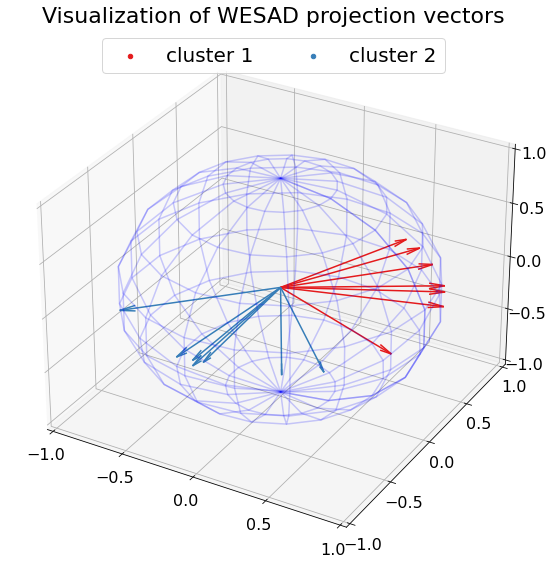

In [59]:
import seaborn as sns
from graspologic.cluster import GaussianCluster as GMM

np.random.seed(1)

train_inds = [tfld.even_sample_inds(y_, p=1, continuous=True).astype(int) for y_ in y_list]
scalers = [tfld.TranslateStandardScale().fit(X_list[i][train_inds[i]], y_list[i][train_inds[i]]) for i in range(n_tasks)]

projections = []
covs = []
for i in range(n_tasks):
    X_ = scalers[i].transform(X_list[i])
    fld = tfld.FLD().fit(X_[train_inds[i]], y_list[i][train_inds[i]])
    target_vector = fld.projection_
    projections.append(target_vector)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]

x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="b", alpha=0.2)

colors=sns.color_palette("Set1", n_colors=8)
colors = [colors[0], colors[1], colors[2]]

gmm = GMM(min_components=1, max_components=5, reg_covar=1e-3).fit(np.array(projections))
gmm_labels = gmm.predict(projections)

for i,proj in enumerate(projections):
    ax.quiver(0,0,0,*proj,length=1.0, arrow_length_ratio=0.1, color=colors[gmm_labels[i]], alpha=1)
    
    
for i,c in enumerate(np.unique(gmm_labels)):
    ax.scatter(-2,-2,-2, c=colors[i], label=f'cluster {i+1}')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
    
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

ax.legend(ncol=3, fontsize=20,loc='upper center')
ax.set_title('Visualization of WESAD projection vectors', fontsize=22)

ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('ecg-projection-vectors-clustered.pdf')

In [47]:
np.random.seed(1)

n_tasks=len(X_list)

n_mc=10
kappas = np.zeros(n_mc)

for j in range(n_mc):
    train_inds = [tfld.even_sample_inds(y_, p=1, continuous=True) for y_ in y_list]

    scalers = [tfld.TranslateStandardScale().fit(X_list[i][train_inds[i]], y_list[i][train_inds[i]]) for i in range(n_tasks)]

    projections = []
    covs = []
    for i in range(n_tasks):
        X_ = scalers[i].transform(X_list[i])
        fld = tfld.FLD().fit(X_[train_inds[i]], y_list[i][train_inds[i]])
        target_vector = fld.projection_
        projections.append(target_vector)

    kappa = tfld.estimate_kappa(projections)
    kappas[j] = kappa
    
print(np.mean(kappas))

1.4542506225981828
